# Asymmetrical exploration for lowrank features with more or less noise

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd

In [2]:
def reduce_best_totalloss(df, id_vars, val_vars):
    best_total_wide = df\
        .groupby(id_vars)\
        .apply(lambda x: x.loc[x['total loss'].idxmin()])\
        .reset_index(drop=True)
    best_total_wide = best_total_wide[id_vars + val_vars]
    return pd.melt(best_total_wide,
                   id_vars=id_vars,
                   var_name='loss', value_name='best_total')

## Different levels of noise

### Load data

In [2]:
noisescales = ['1e-8', '1e-3', '0.1', '0.66', '1.0']
ranks = [5, 8, 12]

dfs = {}
for rank in ranks:
    dfs[rank] = {}
    for noisescale in noisescales:
        df = pd.read_csv('../../data/behaviour/lowrank/'
                         'nnodes=1000-sharedl1=false-decadjdeep=true-'
                         'rank={rank}-noisescale={noisescale}-model=ov7d49f8e167-'
                         'correlation=0:0.2:1-spill=-9:9-dimxi=10:2:20-nsamples=10.csv.gz'
                         .format(rank=rank, noisescale=noisescale),
                         compression='gzip')
        df['rank'] = rank
        df['noisescale'] = float(noisescale)
        dfs[rank][noisescale] = df

data = pd.concat([df for dfsrank in dfs.values() for df in dfsrank.values()])
del df, dfs

In [4]:
data_best = reduce_best_totalloss(data,
                                  ['correlation', 'spill', 'dimξ', 'sample',
                                   'noisescale', 'rank'],
                                  ['adj', 'feat', 'kl', 'reg', 'total loss'])

### Plot data

$\alpha = 1$

/home/slerique/anaconda3/envs/base36-gpu/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


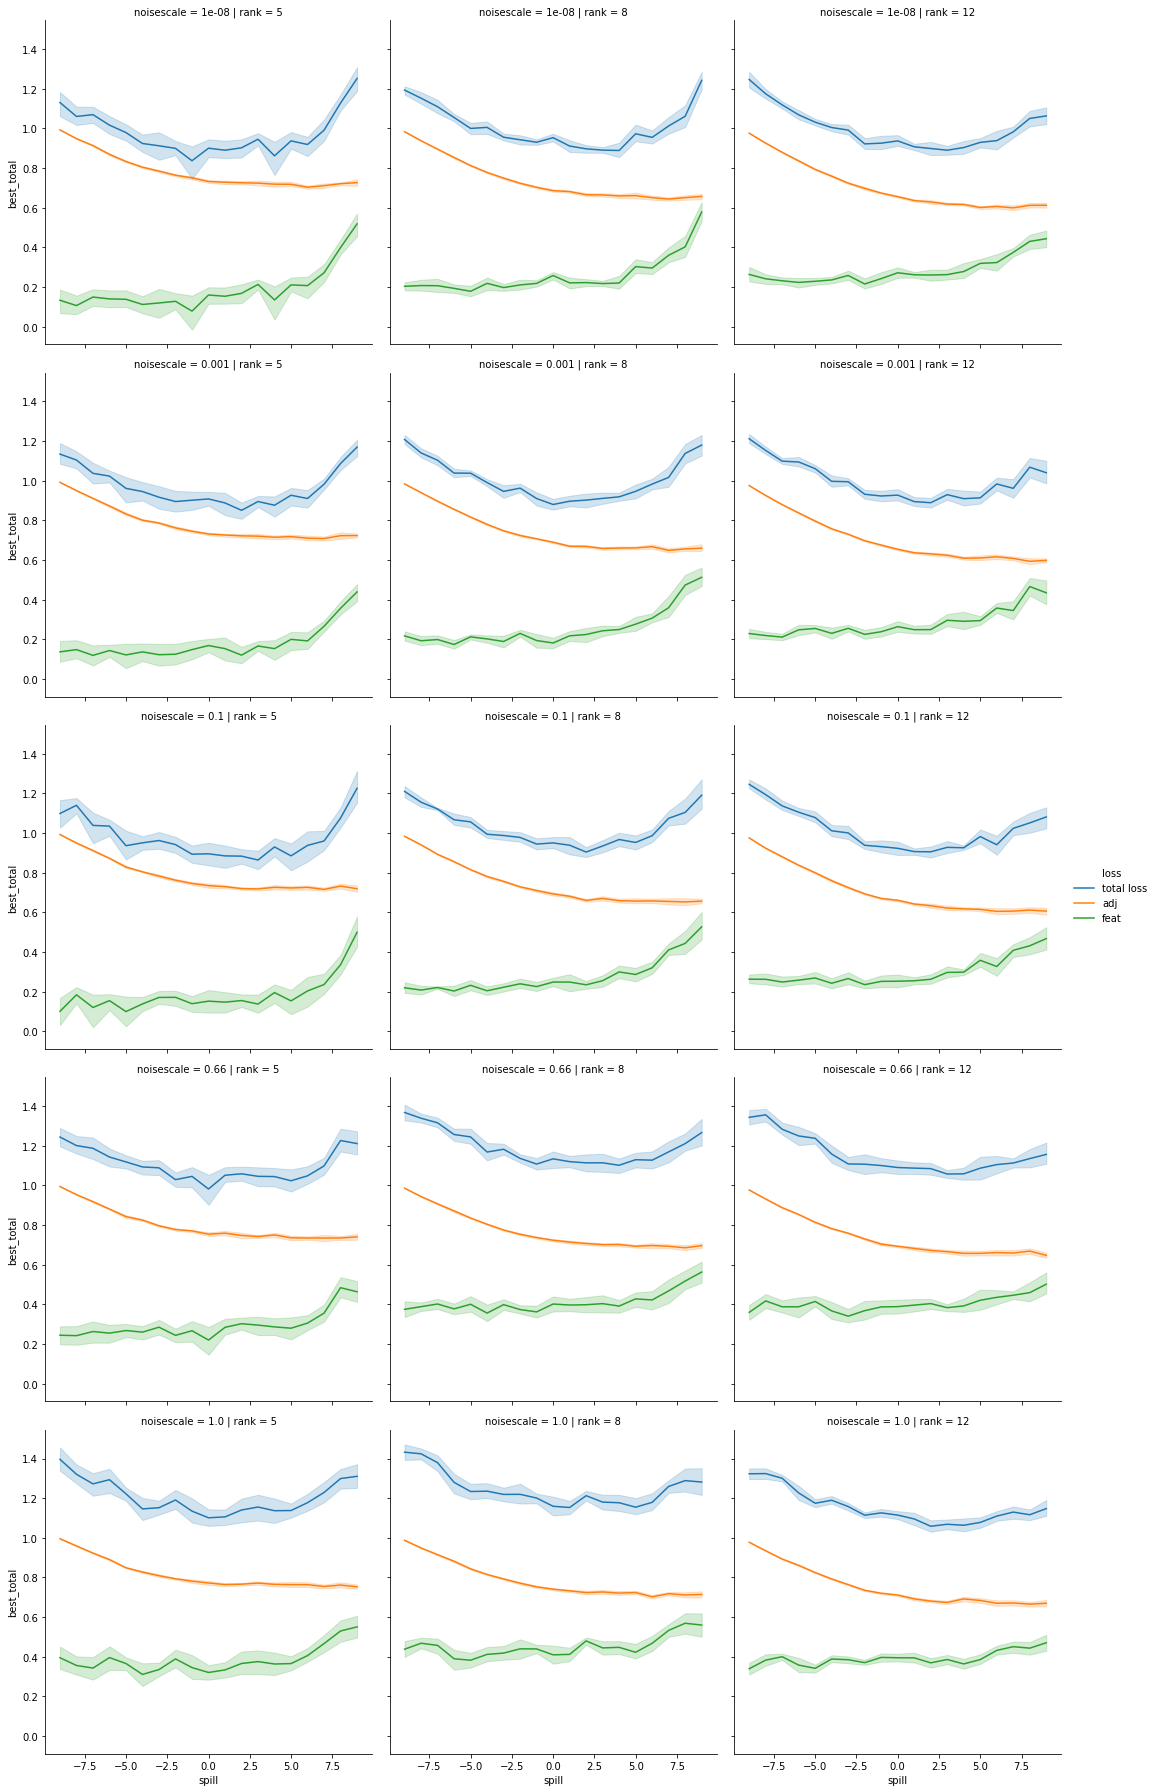

In [5]:
ov = 0
df = data_best[(data_best.dimξ == 20 - ov)]
fg = sb.relplot(x='spill', y='best_total',
                col='rank',
                row='noisescale',
                hue='loss', hue_order=['total loss', 'adj', 'feat'],
                data=df[df.correlation == 1.0],
                kind='line', legend='full', facet_kws={'sharey': True})

$\alpha = 0$

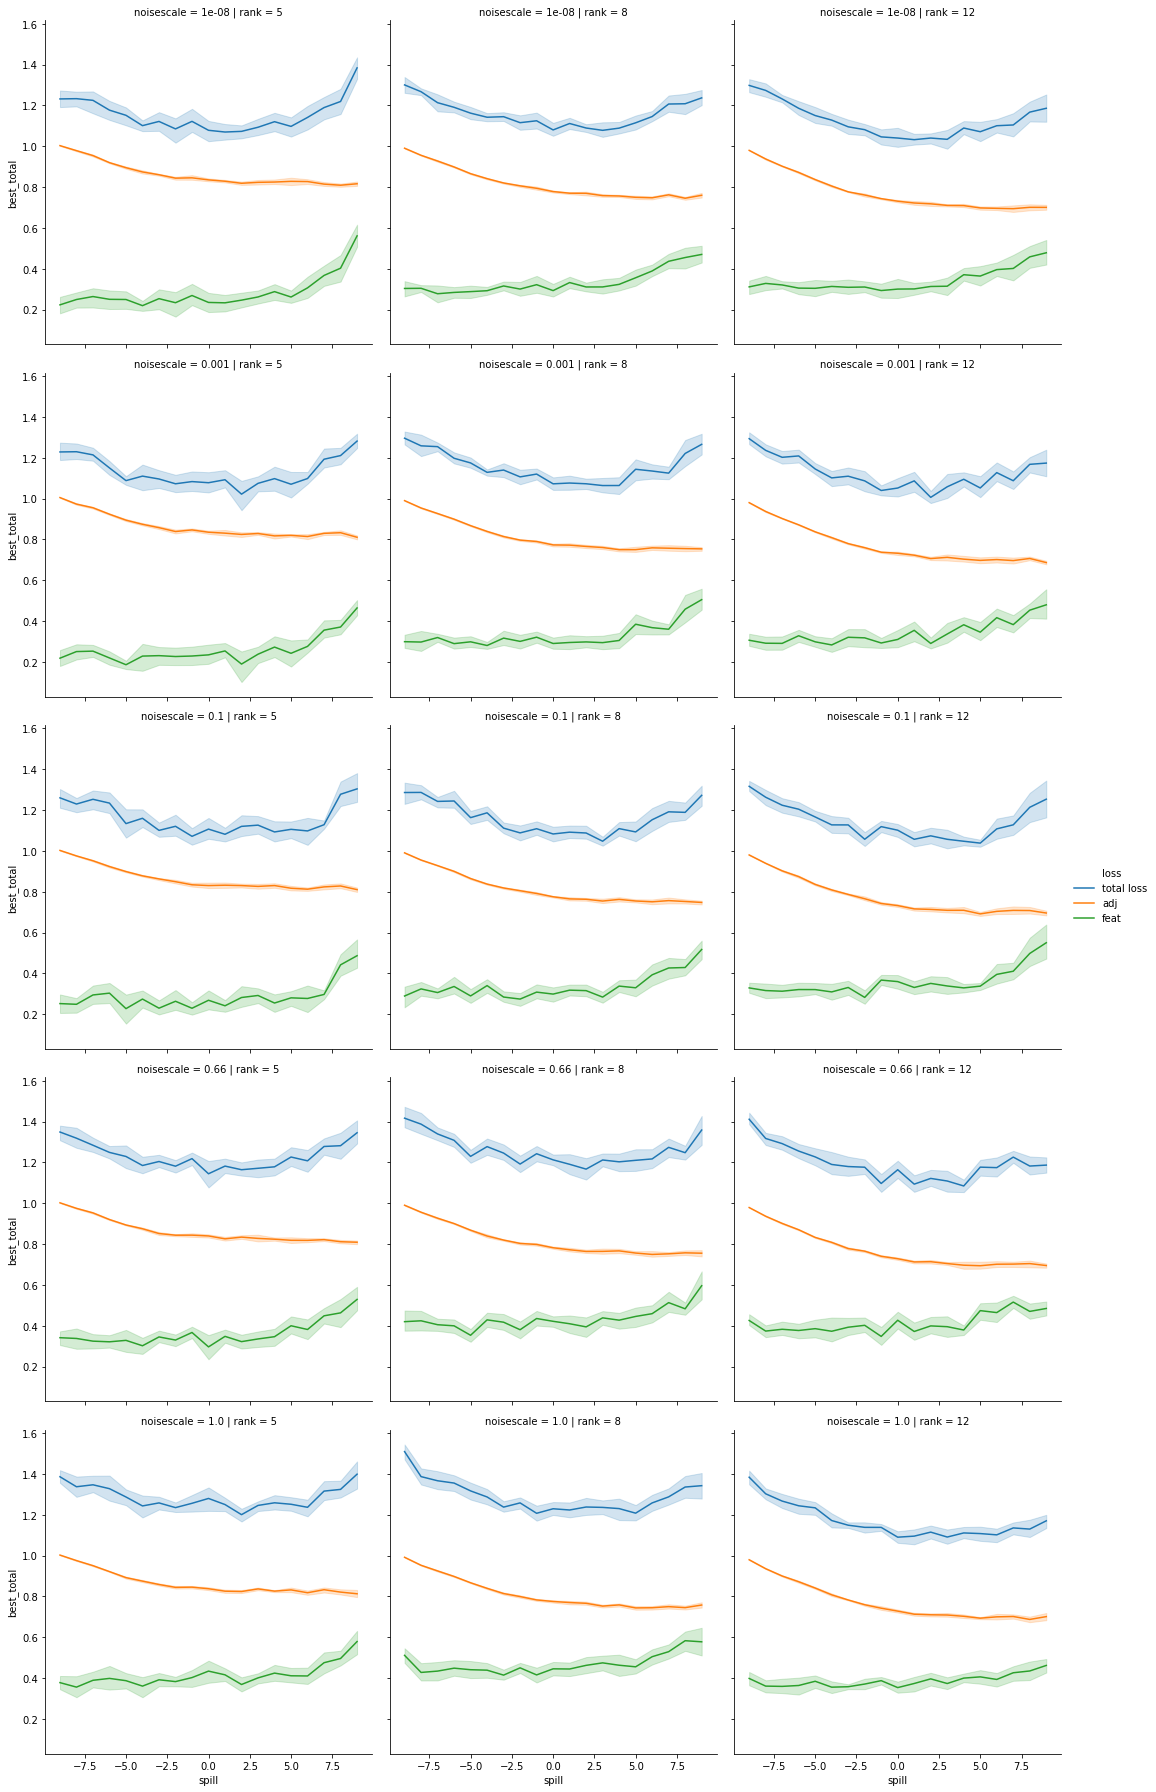

In [6]:
ov = 0
df = data_best[(data_best.dimξ == 20 - ov)]
fg = sb.relplot(x='spill', y='best_total',
                col='rank',
                row='noisescale',
                hue='loss', hue_order=['total loss', 'adj', 'feat'],
                data=df[df.correlation == 0.0],
                kind='line', legend='full', facet_kws={'sharey': True})

Comments:

- Patterns are the same whatever the level of noise, i.e. the model is not affected by the noise levels we put in (it might be with more noise), which is reassuring
- Patterns also mostly don't depend on the correlation level, suggesting that the model doesn't pick up on the correlation between features and structure. This could be related to the high adj loss. Could this be that, in constrast to *colours* or *sbm* where communities are orthogonal in the features, here the model is not able to take advantage of the features for encoding the adjacency.
- The small effect of spill does not come from the noise. It could come from the gaussian decoder, or from the already high adj loss.

## Adding a diagonal matrix to the features

Note: we still decode that diagonal matrix, this might need changing.

In [4]:
df_catdiagtrue = pd.read_csv('../../data/behaviour/lowrank/'
                             'nnodes=1000-sharedl1=false-decadjdeep=true-'
                             'rank=5-noisescale=1.0-catdiag=true-'
                             'model=ov4dba65ea22-correlation=0:0.2:1-spill=-9:9-dimxi=10:2:20-nsamples=10.csv.gz')
df_catdiagfalse = pd.read_csv('../../data/behaviour/lowrank/'
                              'nnodes=1000-sharedl1=false-decadjdeep=true-'
                              'rank=5-noisescale=1.0-catdiag=false-'
                              'model=ov4dba65ea22-correlation=0:0.2:1-spill=-9:9-dimxi=10:2:20-nsamples=10.csv.gz')
dfs_catdiag = pd.concat([df_catdiagtrue, df_catdiagfalse])
del df_catdiagtrue, df_catdiagfalse

In [5]:
dfs_catdiag_best = reduce_best_totalloss(dfs_catdiag,
                                         ['correlation', 'spill', 'dimξ', 'sample',
                                          'noisescale', 'rank', 'catdiag'],
                                         ['adj', 'feat', 'kl', 'reg', 'total loss'])

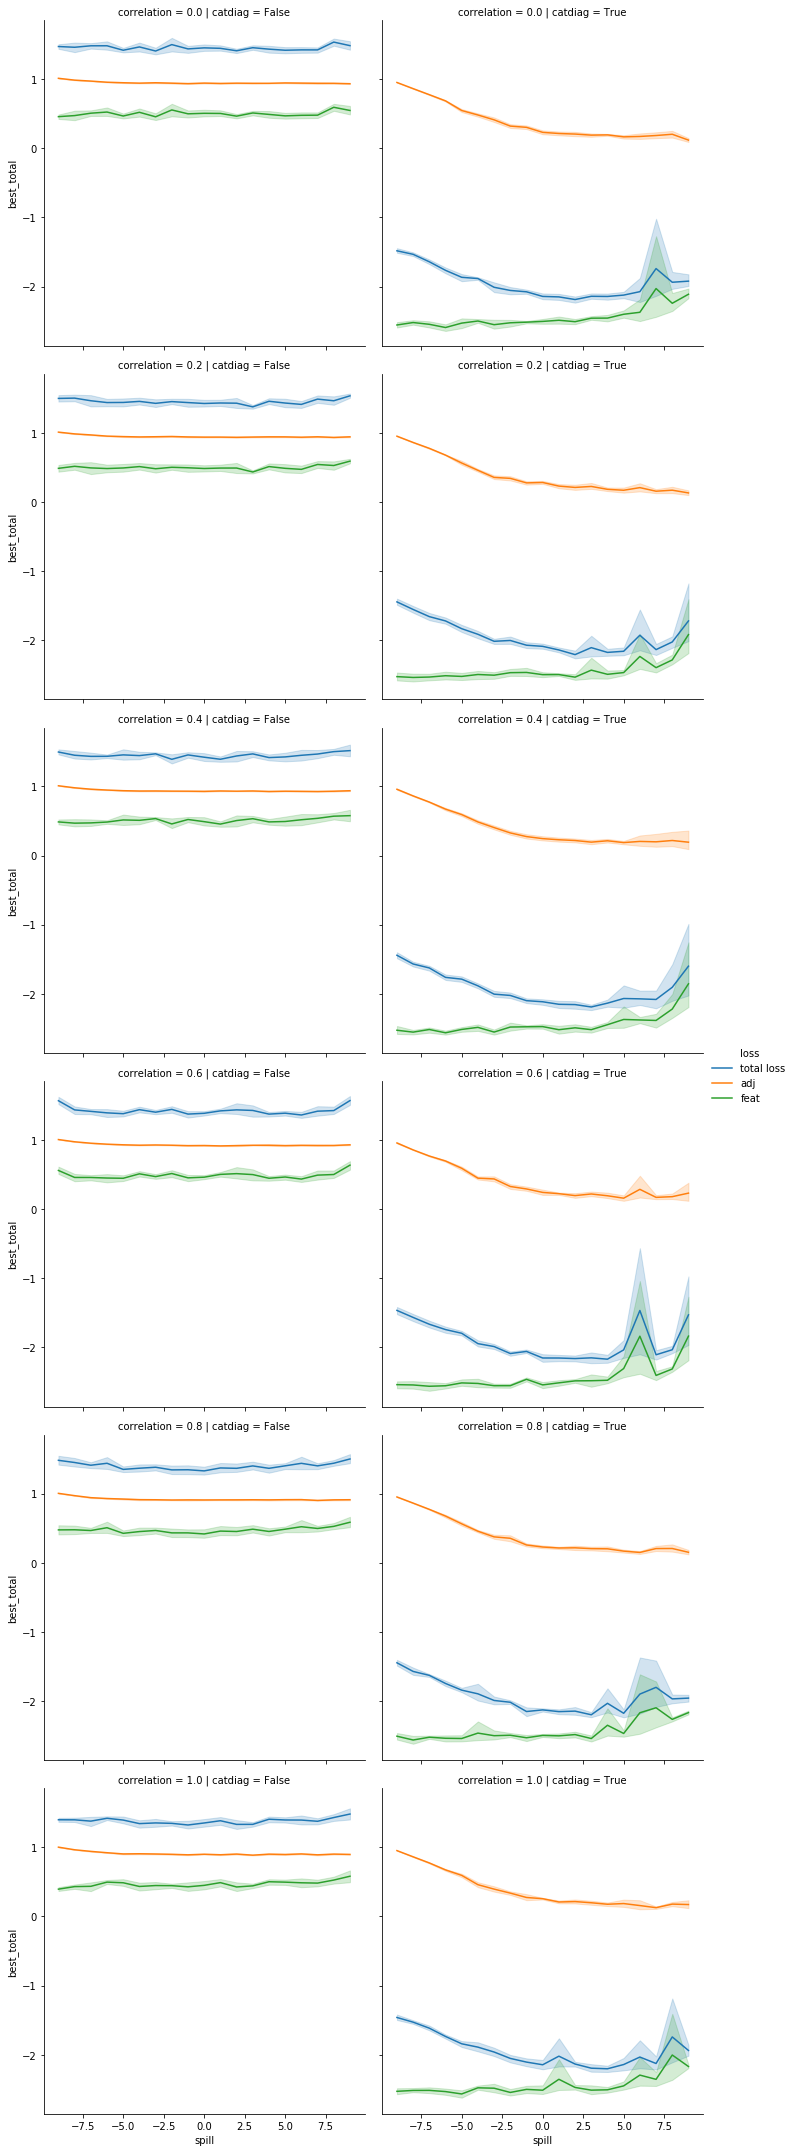

In [9]:
ov = 0
df = dfs_catdiag_best[(dfs_catdiag_best.dimξ == 20 - ov)]
fg = sb.relplot(x='spill', y='best_total',
                col='catdiag',
                row='correlation',
                hue='loss', hue_order=['total loss', 'adj', 'feat'],
                data=df,
                kind='line', legend='full', facet_kws={'sharey': True})

## Adding a diagonal matrix to the features without decoding it

In [3]:
df_catdiagnodectrue = pd.read_csv('../../data/behaviour/lowrank/'
                                  'git=5111cdaaa5-nnodes=1000-sharedl1=false-decadjdeep=true-'
                                  'rank=5-noisescale=1.0-catdiag=true-'
                                  'correlation=0:0.2:1-spill=-9:9-dimxi=10:2:20-nsamples=10.csv.gz')
df_catdiagnodecfalse = pd.read_csv('../../data/behaviour/lowrank/'
                                  'git=5111cdaaa5-nnodes=1000-sharedl1=false-decadjdeep=true-'
                                  'rank=5-noisescale=1.0-catdiag=false-'
                                  'correlation=0:0.2:1-spill=-9:9-dimxi=10:2:20-nsamples=10.csv.gz')
dfs_catdiagnodec = pd.concat([df_catdiagnodectrue, df_catdiagnodecfalse])
del df_catdiagnodectrue, df_catdiagnodecfalse

In [4]:
dfs_catdiagnodec_best = reduce_best_totalloss(dfs_catdiagnodec,
                                              ['correlation', 'spill', 'dimξ', 'sample',
                                               'noisescale', 'rank', 'catdiag'],
                                              ['adj', 'feat', 'kl', 'reg', 'total loss'])

/home/slerique/anaconda3/envs/base36-gpu/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


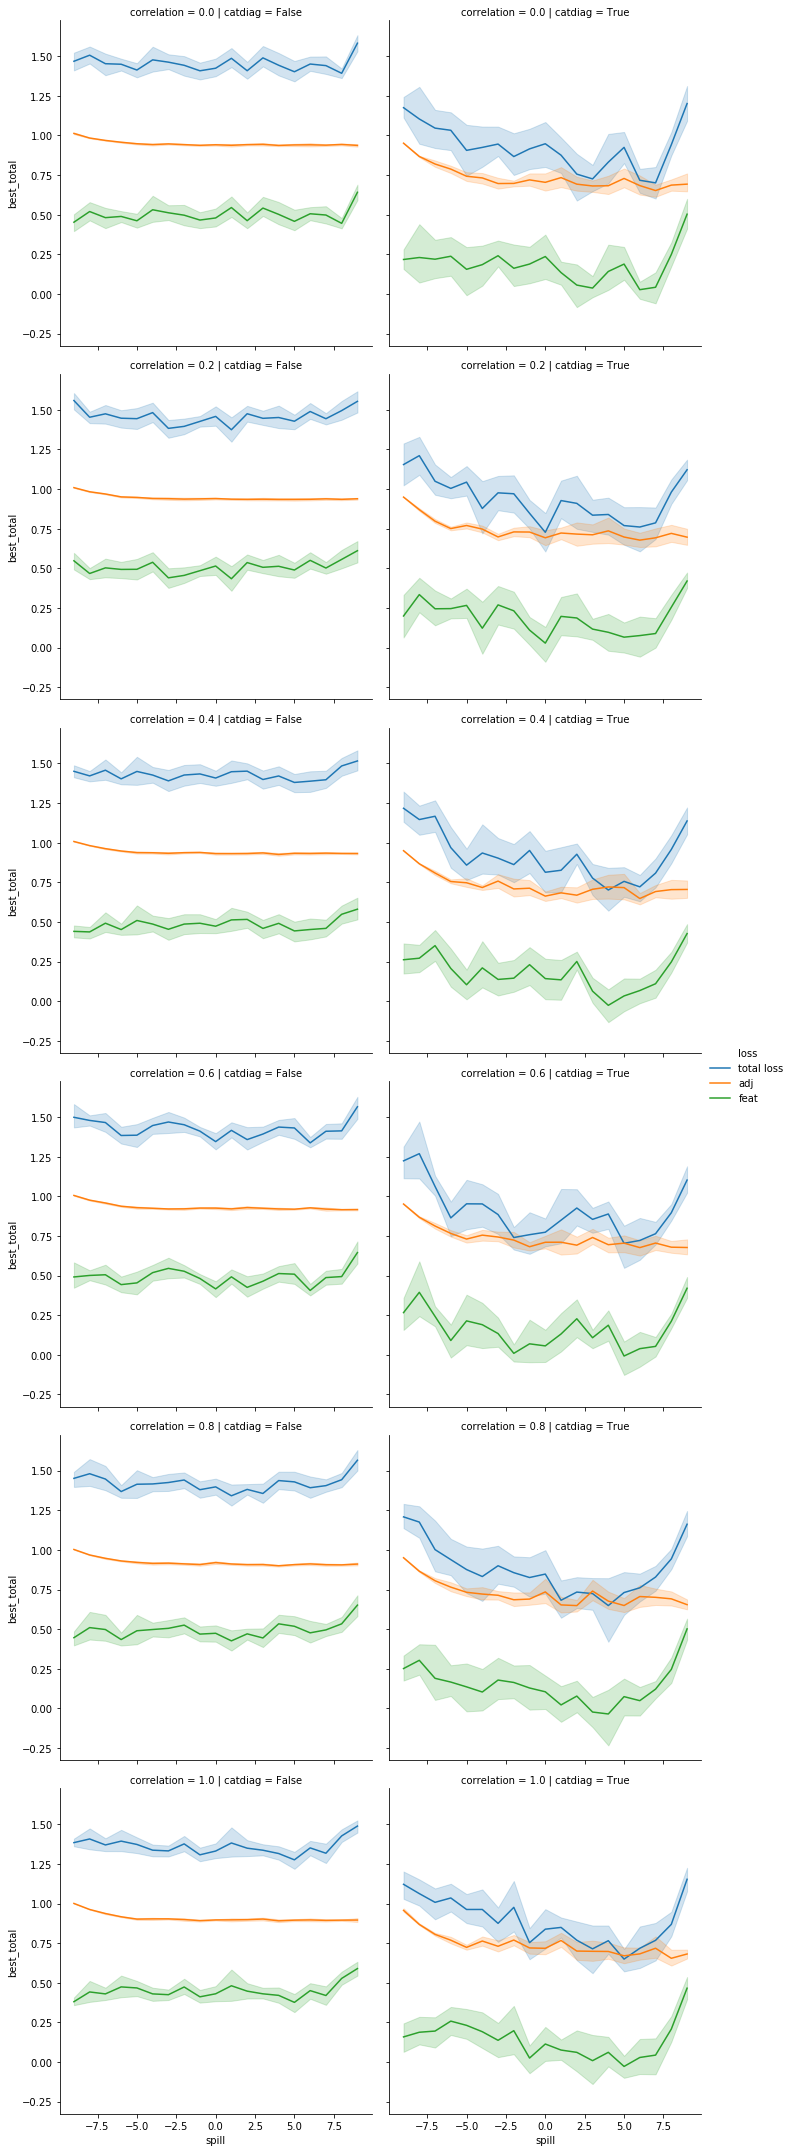

In [5]:
ov = 0
df = dfs_catdiagnodec_best[(dfs_catdiagnodec_best.dimξ == 20 - ov)]
fg = sb.relplot(x='spill', y='best_total',
                col='catdiag',
                row='correlation',
                hue='loss', hue_order=['total loss', 'adj', 'feat'],
                data=df,
                kind='line', legend='full', facet_kws={'sharey': True})

## Adding a diagonal matrix to the features without decoding it, with `diml1dec = diml1enc`

In [3]:
#df_catdiagnodec_equaldec_true = pd.read_csv('../../data/behaviour/lowrank/'
#                                  'git=cff37329d1-nnodes=1000-sharedl1=false-decadjdeep=true-'
#                                  'rank=5-noisescale=1.0-catdiag=true-'
#                                  'correlation=0:0.2:1-spill=-9:9-dimxi=10:2:20-nsamples=10.csv.gz')
df_catdiagnodec_equaldec_false = pd.read_csv('../../data/behaviour/lowrank/'
                                  'git=cff37329d1-nnodes=1000-sharedl1=false-decadjdeep=true-'
                                  'rank=5-noisescale=1.0-catdiag=false-'
                                  'correlation=0:0.2:1-spill=-9:9-dimxi=10:2:20-nsamples=10.csv.gz')
dfs_catdiagnodec_equaldec = pd.concat([df_catdiagnodec_equaldec_false])#, df_catdiagnodec_equaldec_true])
del df_catdiagnodec_equaldec_false#, df_catdiagnodec_equaldec_true

In [4]:
dfs_catdiagnodec_equaldec_best = reduce_best_totalloss(dfs_catdiagnodec_equaldec,
                                              ['correlation', 'spill', 'dimξ', 'sample',
                                               'noisescale', 'rank', 'catdiag'],
                                              ['adj', 'feat', 'kl', 'reg', 'total loss'])

/home/slerique/anaconda3/envs/base36-gpu/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


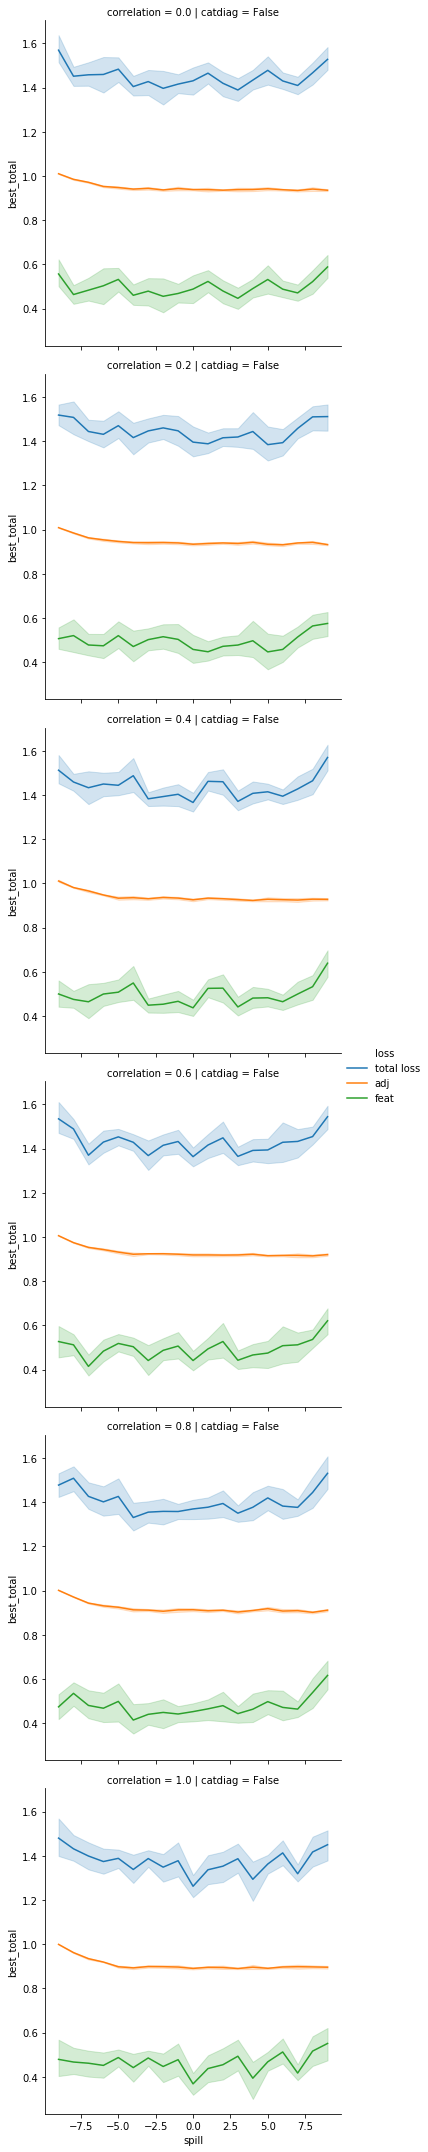

In [5]:
ov = 0
df = dfs_catdiagnodec_equaldec_best[(dfs_catdiagnodec_equaldec_best.dimξ == 20 - ov)]
fg = sb.relplot(x='spill', y='best_total',
                col='catdiag',
                row='correlation',
                hue='loss', hue_order=['total loss', 'adj', 'feat'],
                data=df,
                kind='line', legend='full', facet_kws={'sharey': True})